### Library imports

In [3]:
# FathomNet 2025 @ CVPR-FGVC Competition
# Taxonomy-Aware Hierarchical Classifier

import os
import pandas as pd
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
# from torchvision.models import convnextv2_base, ConvNeXtV2_Base_Weights
import timm
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.multiclass import unique_labels
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import torchvision
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
warnings.filterwarnings('ignore')


/mnt/beegfs/home/dzimmerman2021/miniconda/envs/fathomnet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Configuration

In [ ]:
# Path config
DATA_ROOT = "/mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/"

class Config:
    # Paths
    TAXONOMY_PATH = os.path.join(DATA_ROOT, "taxonomy.csv")
    TRAIN_ANNOTATIONS = os.path.join(DATA_ROOT, "train", "annotations.csv")
    TRAIN_IMAGE_DIR = os.path.join(DATA_ROOT, "train", "rois")
    TEST_ANNOTATIONS = os.path.join(DATA_ROOT, "test", "annotations.csv")
    TEST_IMAGE_DIR = os.path.join(DATA_ROOT, "test", "rois")
    OUTPUT_DIR = os.path.join(DATA_ROOT, "outputs")
    SUBMISSION_PATH = os.path.join(DATA_ROOT, "submission.csv")
    
    # Training parameters
    BATCH_SIZE = 32
    NUM_WORKERS = 8
    MAX_EPOCHS = 50
    LEARNING_RATE = 3e-4
    WEIGHT_DECAY = 0.05
    LABEL_SMOOTHING = 0.1
    
    # Model parameters
    IMG_SIZE = 224
    BACKBONE = "convnext_basev2"
    
    # Taxonomic levels
    TAXONOMY_LEVELS = ["kingdom", "phylum", "class", "order", "family", "genus", "species"]
    
    # Inference parameters
    CONFIDENCE_THRESHOLD = 0.7
    
def check_path(path, is_dir=False):
    exists = os.path.exists(path)
    if not exists:
        return f"NOT FOUND: {path}"
    else:
        if is_dir:
            return f"Directory found: {path}"
        else:
            return f"File found: {path}"

print("Checking configured paths:")
print(check_path(Config.TAXONOMY_PATH))
print(check_path(Config.TRAIN_ANNOTATIONS))
print(check_path(Config.TRAIN_IMAGE_DIR, is_dir=True))
print(check_path(Config.TEST_ANNOTATIONS))
print(check_path(Config.TRAIN_IMAGE_DIR, is_dir=True))
print(f"Output will be saved to: {os.path.abspath(Config.OUTPUT_DIR)}")

# Create output directory if it doesn't exist
os.makedirs(Config.OUTPUT_DIR, exist_ok=True)

Checking configured paths:
File found: /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/taxonomy.csv
File found: /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/train/annotations.csv
Directory found: /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/train/rois
File found: /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/test/annotations.csv
Directory found: /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/train/rois
Output will be saved to: /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/outputs


### Initialize vars

In [5]:
# Pipeline Control Panel
RUN_EXPLORATION = True       # Explore the dataset
RUN_TRAINING = True          # Train a new model
LOAD_PRETRAINED = False      # Instead of training, load a pretrained model
PRETRAINED_PATH = os.path.join(DATA_ROOT, "outputs", "best_model.ckpt")  # Path to pretrained model if LOAD_PRETRAINED=True
RUN_ANALYSIS = True          # Analyze model performance
GENERATE_SUBMISSION = True   # Generate submission file

# Initialize variables we'll need later
train_loader = None
val_loader = None
test_loader = None
taxonomy_df = None
encoders = None
class_counts = None
id_to_name = None
name_to_id = None
best_model_path = None

### Taxonomy Encoding

In [6]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

def load_and_encode_taxonomy():
    print("Loading taxonomy data...")
    taxonomy_df = pd.read_csv(Config.TAXONOMY_PATH)

    encoders = {}
    class_counts = {}
    id_to_name = {}
    name_to_id = {}

    for level in Config.TAXONOMY_LEVELS:
        if level not in taxonomy_df.columns:
            print(f"Warning: '{level}' not found in taxonomy data!")
            continue

        # Fill missing values and normalize text
        taxonomy_df[level] = taxonomy_df[level].fillna("unknown").astype(str).str.strip()

        # Make sure "unknown" is included as a class
        unique_labels = taxonomy_df[level].unique().tolist()
        if "unknown" not in unique_labels:
            unique_labels.append("unknown")

        le = LabelEncoder()
        le.fit(unique_labels)

        # Encode and store
        taxonomy_df[f"{level}_id"] = le.transform(taxonomy_df[level])
        encoders[level] = le
        class_counts[level] = len(le.classes_)
        id_to_name[level] = {i: name for i, name in enumerate(le.classes_)}
        name_to_id[level] = {name: i for i, name in enumerate(le.classes_)}

        print(f"{level.capitalize():<8}: {class_counts[level]:>3} classes")

    return taxonomy_df, encoders, class_counts, id_to_name, name_to_id


### Dataset classes

In [7]:
class FathomNetTaxonomyDataset(Dataset):
    # Dataset for FathomNet with taxonomic information.    
    def __init__(self, image_paths, species_names, taxonomy_df, encoders, transform=None):
        self.image_paths = image_paths
        self.species_names = species_names
        self.taxonomy_df = taxonomy_df
        self.encoders = encoders
        self.transform = transform
        
        # Pre-compute taxonomic info for faster access
        self.taxonomic_info = []
        for species in species_names:
            row = self.taxonomy_df[self.taxonomy_df['species'] == species]
            if row.empty:
                print(f"Warning: Species '{species}' not found in taxonomy_df")
                # Use a default row
                self.taxonomic_info.append({level: 0 for level in Config.TAXONOMY_LEVELS})
            else:
                row = row.iloc[0]
                self.taxonomic_info.append({
                    level: int(row[f'{level}_id']) for level in Config.TAXONOMY_LEVELS 
                    if f'{level}_id' in row
                })

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        # Handle image loading errors gracefully
        try:
            img = Image.open(img_path).convert("RGB")
            if self.transform:
                img = self.transform(img)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image of the correct size
            img = torch.zeros(3, Config.IMG_SIZE, Config.IMG_SIZE)
        
        # Return image and taxonomic labels
        result = {'image': img}
        result.update(self.taxonomic_info[idx])
        
        return result

class FathomNetTestDataset(Dataset):
    # Dataset for FathomNet test set without labels.
    def __init__(self, image_paths, annotation_ids, transform=None):
        self.image_paths = image_paths
        self.annotation_ids = annotation_ids
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        annotation_id = self.annotation_ids[idx]
        
        # Handle image loading errors gracefully
        try:
            img = Image.open(img_path).convert("RGB")
            if self.transform:
                img = self.transform(img)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image of the correct size
            img = torch.zeros(3, Config.IMG_SIZE, Config.IMG_SIZE)
        
        return {'image': img, 'annotation_id': annotation_id}

def collate_fn(batch):
    """Custom collate function to handle the taxonomy dataset."""
    images = torch.stack([b['image'] for b in batch])
    
    # Collect labels for each taxonomic level
    labels = {}
    for level in Config.TAXONOMY_LEVELS:
        if level in batch[0]:
            labels[level] = torch.tensor([b[level] for b in batch])
    
    return images, labels

def test_collate_fn(batch):
    """Custom collate function for test dataset."""
    images = torch.stack([b['image'] for b in batch])
    annotation_ids = [b['annotation_id'] for b in batch]
    
    return images, annotation_ids

### Data transformations

In [8]:
def create_transforms():
    # Create augmentation pipelines for train and validation/test sets.
    # Training - strong augmentation to help with model generalization
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(Config.IMG_SIZE, scale=(0.5, 1.0)),  # Handle size variation
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Validation/Test - just resize and normalize
    val_transform = transforms.Compose([
        transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

### Hierarchical Neural Network Model

In [9]:
class TaxonomyAwareClassifier(pl.LightningModule):
    def __init__(self, class_counts, lr=Config.LEARNING_RATE):
        super().__init__()
        self.save_hyperparameters()
        self.class_counts = class_counts
        self.lr = lr

        # Load pretrained backbone
        # weights = ConvNeXt_Base_Weights.DEFAULT
        # backbone = convnextv2_base(weights=weights)
        # self.feature_extractor = nn.Sequential(*(list(backbone.children())[:-2]))
        # in_features = backbone.classifier[2].in_features
        
        # Load ConvNeXt v2 from timm
        backbone = timm.create_model(
            'convnextv2_base.fcmae_ft_in22k_in1k', 
            pretrained=True,
            num_classes=0  # Remove classification head
        )
        self.feature_extractor = backbone
        in_features = backbone.num_features
        
        # Shared feature processing
        self.shared_features = nn.Sequential(
            nn.LayerNorm(in_features),
            nn.Linear(in_features, 1024),
            nn.GELU(),
            nn.Dropout(0.2),
        )

        # Create 7-level hierarchical classifier
        self._create_hierarchical_network(class_counts)

        # Loss
        self.criterion = nn.CrossEntropyLoss(label_smoothing=Config.LABEL_SMOOTHING)

        # Tracking
        self.val_step_outputs = []

    def _create_hierarchical_network(self, class_counts):
        # Heads
        self.kingdom_head = nn.Linear(1024, class_counts['kingdom'])
        self.kingdom_to_phylum = nn.Linear(class_counts['kingdom'], 512)
        self.phylum_features = nn.Linear(1024, 512)
        self.phylum_head = nn.Linear(1024, class_counts['phylum'])

        self.phylum_to_class = nn.Linear(class_counts['phylum'], 512)
        self.class_features = nn.Linear(1024, 512)
        self.class_head = nn.Linear(1024, class_counts['class'])

        self.class_to_order = nn.Linear(class_counts['class'], 512)
        self.order_features = nn.Linear(1024, 512)
        self.order_head = nn.Linear(1024, class_counts['order'])

        self.order_to_family = nn.Linear(class_counts['order'], 512)
        self.family_features = nn.Linear(1024, 512)
        self.family_head = nn.Linear(1024, class_counts['family'])

        self.family_to_genus = nn.Linear(class_counts['family'], 512)
        self.genus_features = nn.Linear(1024, 512)
        self.genus_head = nn.Linear(1024, class_counts['genus'])

        self.genus_to_species = nn.Linear(class_counts['genus'], 512)
        self.species_features = nn.Linear(1024, 512)
        self.species_head = nn.Linear(1024, class_counts['species'])

    def forward(self, x):
        features = self.feature_extractor(x)
        # Removed for convnextv2
        # features = nn.functional.adaptive_avg_pool2d(features, (1, 1)).squeeze(-1).squeeze(-1)
        shared = self.shared_features(features)

        # Predict hierarchy
        kingdom_logits = self.kingdom_head(shared)
        kingdom_probs = torch.softmax(kingdom_logits, dim=1)

        phylum_input = self.kingdom_to_phylum(kingdom_probs)
        phylum_feats = self.phylum_features(shared)
        phylum_logits = self.phylum_head(torch.cat([phylum_input, phylum_feats], dim=1))
        phylum_probs = torch.softmax(phylum_logits, dim=1)

        class_input = self.phylum_to_class(phylum_probs)
        class_feats = self.class_features(shared)
        class_logits = self.class_head(torch.cat([class_input, class_feats], dim=1))
        class_probs = torch.softmax(class_logits, dim=1)

        order_input = self.class_to_order(class_probs)
        order_feats = self.order_features(shared)
        order_logits = self.order_head(torch.cat([order_input, order_feats], dim=1))
        order_probs = torch.softmax(order_logits, dim=1)

        family_input = self.order_to_family(order_probs)
        family_feats = self.family_features(shared)
        family_logits = self.family_head(torch.cat([family_input, family_feats], dim=1))
        family_probs = torch.softmax(family_logits, dim=1)

        genus_input = self.family_to_genus(family_probs)
        genus_feats = self.genus_features(shared)
        genus_logits = self.genus_head(torch.cat([genus_input, genus_feats], dim=1))
        genus_probs = torch.softmax(genus_logits, dim=1)

        species_input = self.genus_to_species(genus_probs)
        species_feats = self.species_features(shared)
        species_logits = self.species_head(torch.cat([species_input, species_feats], dim=1))

        return {
            'kingdom': kingdom_logits,
            'phylum': phylum_logits,
            'class': class_logits,
            'order': order_logits,
            'family': family_logits,
            'genus': genus_logits,
            'species': species_logits,
        }

    
    def hierarchical_loss(self, outputs, targets):
        # Calculate hierarchical loss with weighting for different levels.        
        losses = {}
        total_loss = 0.0
        weights = {
            'kingdom': 0.5,
            'phylum': 0.75,
            'class': 1.0,
            'order': 1.25,
            'family': 1.5,
            'genus': 2.0,
            'species': 2.5
        }
        
        # Calculate losses for each available level
        for level in Config.TAXONOMY_LEVELS:
            if level in outputs and level in targets:
                level_loss = self.criterion(outputs[level], targets[level])
                losses[level] = level_loss
                total_loss += weights[level] * level_loss
        
        # Normalize by total weight
        total_weight = sum(weights[l] for l in losses.keys())
        return total_loss / total_weight, losses
    
    def training_step(self, batch, batch_idx):
        # Unpack batch
        x, y = batch
        
        # Forward pass
        outputs = self(x)
        
        # Calculate loss
        loss, level_losses = self.hierarchical_loss(outputs, y)
        
        # Log metrics
        self.log("train_loss", loss, prog_bar=True)
        for level, level_loss in level_losses.items():
            self.log(f"train_{level}_loss", level_loss, prog_bar=False)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        # Unpack batch
        x, y = batch
        
        # Forward pass
        outputs = self(x)
        
        # Calculate loss
        loss, level_losses = self.hierarchical_loss(outputs, y)
        
        # Calculate accuracy for each level
        accuracy = {}
        for level in Config.TAXONOMY_LEVELS:
            if level in outputs and level in y:
                preds = torch.argmax(outputs[level], dim=1)
                acc = (preds == y[level]).float().mean()
                accuracy[level] = acc
        
        # Log metrics
        self.log("val_loss", loss, prog_bar=True, sync_dist=True)
        for level, level_loss in level_losses.items():
            self.log(f"val_{level}_loss", level_loss, prog_bar=False, sync_dist=True)
            
        for level, acc in accuracy.items():
            self.log(f"val_{level}_acc", acc, prog_bar=True, sync_dist=True)
        
        # Store outputs for epoch end processing
        self.val_step_outputs.append({
            'outputs': outputs,
            'targets': y
        })
        
        return loss
    
    def on_validation_epoch_end(self):
        # Skip if no validation steps were performed
        if not self.val_step_outputs:
            return
        
        # Collect all predictions and targets
        all_preds = {level: [] for level in Config.TAXONOMY_LEVELS}
        all_targets = {level: [] for level in Config.TAXONOMY_LEVELS}
        
        for output in self.val_step_outputs:
            for level in Config.TAXONOMY_LEVELS:
                if level in output['outputs'] and level in output['targets']:
                    pred = torch.argmax(output['outputs'][level], dim=1).cpu()
                    target = output['targets'][level].cpu()
                    all_preds[level].append(pred)
                    all_targets[level].append(target)
        
        # Concatenate predictions and targets
        for level in Config.TAXONOMY_LEVELS:
            if all_preds[level]:
                all_preds[level] = torch.cat(all_preds[level])
                all_targets[level] = torch.cat(all_targets[level])
        
        # Calculate overall accuracy for each level
        for level in Config.TAXONOMY_LEVELS:
            if len(all_preds[level]) > 0:
                acc = (all_preds[level] == all_targets[level]).float().mean()
                self.log(f"val_{level}_acc_epoch", acc, prog_bar=True)
        
        # Clear stored outputs
        self.val_step_outputs.clear()
    
    def predict_step(self, batch, batch_idx):
        # Generate predictions for test data
        # Handle both batched images and (images, _) tuples
        if isinstance(batch, tuple) and len(batch) == 2:
            images, annotation_ids = batch
        else:
            images = batch
            annotation_ids = None
        
        # Forward pass
        outputs = self(images)
        
        # Get probabilities and predictions for each level
        results = {}
        for level in Config.TAXONOMY_LEVELS:
            if level in outputs:
                probs = torch.softmax(outputs[level], dim=1)
                preds = torch.argmax(probs, dim=1)
                conf = torch.gather(probs, 1, preds.unsqueeze(1)).squeeze(1)
                
                results[level] = {
                    'pred': preds.cpu(),
                    'conf': conf.cpu(),
                    'probs': probs.cpu()
                }
        
        if annotation_ids is not None:
            results['annotation_ids'] = annotation_ids
            
        return results
    
    def configure_optimizers(self):
        # Configure optimizers with different learning rates for backbone vs heads
        # Group parameters by part of the model
        backbone_params = self.feature_extractor.parameters()
        classifier_params = [p for n, p in self.named_parameters() 
                            if "feature_extractor" not in n]
        
        # Create parameter groups with different learning rates
        param_groups = [
            {'params': backbone_params, 'lr': self.lr / 10},  # Lower LR for backbone
            {'params': classifier_params, 'lr': self.lr}
        ]
        
        # Create optimizer
        optimizer = torch.optim.AdamW(param_groups, weight_decay=Config.WEIGHT_DECAY)
        
        # Create learning rate scheduler
        scheduler = {
            "scheduler": torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, T_0=5, T_mult=2, eta_min=1e-6
            ),
            "interval": "epoch",
            "frequency": 1,
        }
        
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

### Data preparation

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

def prepare_data():
    print("Preparing datasets...")

    # Load annotations
    annotations = pd.read_csv(Config.TRAIN_ANNOTATIONS)
    image_paths = [os.path.join(Config.TRAIN_IMAGE_DIR, p) for p in annotations['path']]
    species_names = annotations['label'].tolist()
    
    # Step 1: 70% train, 30% temp (val + eval)
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
    train_idx, temp_idx = next(sss1.split(image_paths, species_names))
    train_paths = [image_paths[i] for i in train_idx]
    train_species = [species_names[i] for i in train_idx]
    temp_paths = [image_paths[i] for i in temp_idx]
    temp_species = [species_names[i] for i in temp_idx]

    # Step 2: 15% val, 15% eval (split 30% temp set into 50/50)
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    val_idx, eval_idx = next(sss2.split(temp_paths, temp_species))
    val_paths = [temp_paths[i] for i in val_idx]
    val_species = [temp_species[i] for i in val_idx]
    eval_paths = [temp_paths[i] for i in eval_idx]
    eval_species = [temp_species[i] for i in eval_idx]

    # Create transforms
    train_transform, val_transform = create_transforms()

    # Load taxonomy
    taxonomy_df, encoders, class_counts, id_to_name, name_to_id = load_and_encode_taxonomy()

    # Create datasets
    train_dataset = FathomNetTaxonomyDataset(train_paths, train_species, taxonomy_df, encoders, transform=train_transform)
    val_dataset = FathomNetTaxonomyDataset(val_paths, val_species, taxonomy_df, encoders, transform=val_transform)
    eval_dataset = FathomNetTaxonomyDataset(eval_paths, eval_species, taxonomy_df, encoders, transform=val_transform)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS, collate_fn=collate_fn, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=Config.NUM_WORKERS, collate_fn=collate_fn, pin_memory=True)
    eval_loader = DataLoader(eval_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=Config.NUM_WORKERS, collate_fn=collate_fn, pin_memory=True)

    print(f"Train dataset: {len(train_dataset)} images")
    print(f"Validation dataset: {len(val_dataset)} images")
    print(f"Internal evaluation dataset: {len(eval_dataset)} images")

    return train_loader, val_loader, eval_loader, taxonomy_df, encoders, class_counts, id_to_name, name_to_id

### Training function

In [11]:
def train_model(train_loader, val_loader, class_counts):
    # Train the model using PyTorch Lightning.    
    print("Starting model training...")
    
    # Create model
    model = TaxonomyAwareClassifier(class_counts=class_counts)
    
    # Create callbacks
    checkpoint_callback = ModelCheckpoint(
        dirpath=Config.OUTPUT_DIR,
        filename='fathomnet-{epoch:02d}-{val_loss:.4f}',
        save_top_k=3,
        monitor='val_loss',
        mode='min'
    )
    
    early_stop_callback = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min'
    )
    
    lr_monitor = LearningRateMonitor(logging_interval='epoch')
    
    # Create trainer
    trainer = pl.Trainer(
        max_epochs=Config.MAX_EPOCHS,
        accelerator="gpu",
        devices=1,  # Use all available GPUs
        # strategy="dp",  # Data Parallel
        precision=16,  # Mixed precision for faster training
        callbacks=[checkpoint_callback, early_stop_callback, lr_monitor],
        log_every_n_steps=10,
        default_root_dir=Config.OUTPUT_DIR
    )
    
    # Train model
    trainer.fit(model, train_loader, val_loader)
    
    # Return best model path
    return checkpoint_callback.best_model_path

### Test Data Preparation

In [12]:
def prepare_test_data(taxonomy_df):
    """Prepare test dataset and dataloader."""
    
    print("Preparing test dataset...")
    
    # Load test annotations
    test_annotations = pd.read_csv(Config.TEST_ANNOTATIONS)
    test_image_paths = [os.path.join(Config.TEST_IMAGE_DIR, p) for p in test_annotations['path']]
    
    # Use row indices as IDs since there's no annotation_id column
    test_annotation_ids = list(range(len(test_annotations)))
    
    print(f"Using row indices (0 to {len(test_annotations)-1}) as annotation IDs")
    
    # Create transforms
    _, test_transform = create_transforms()
    
    # Create test dataset
    test_dataset = FathomNetTestDataset(
        test_image_paths, test_annotation_ids, transform=test_transform
    )
    
    # Create test dataloader
    test_loader = DataLoader(
        test_dataset, 
        batch_size=Config.BATCH_SIZE, 
        shuffle=False, 
        num_workers=Config.NUM_WORKERS, 
        collate_fn=test_collate_fn
    )
    
    print(f"Test dataset: {len(test_dataset)} images")
    
    return test_loader

### Inference and submission

In [13]:
import pandas as pd

taxonomy_df = pd.read_csv(Config.TAXONOMY_PATH)
taxonomy_df = taxonomy_df.dropna(subset=["species"])  # filter nulls


In [14]:
from collections import defaultdict

# Create mappings from each level to most common species
fallback_levels = ['genus', 'family', 'order', 'class', 'phylum', 'kingdom']
fallback_mappings = {level: defaultdict(str) for level in fallback_levels}

# Populate mappings using most common species per higher level
for level in fallback_levels:
    grouped = taxonomy_df.groupby(level)['species'].agg(lambda x: x.value_counts().idxmax())
    for k, v in grouped.items():
        fallback_mappings[level][k] = v

print("Fallback mappings for full taxonomy created.")


Fallback mappings for full taxonomy created.


### Evaluation

In [15]:
def evaluate_model(model, dataloader, class_counts, id_to_name, name="Evaluation"):
    print(f"\n{'='*60}")
    print(f"RUNNING {name.upper()} METRICS")
    print(f"{'='*60}\n")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
    name_slug = name.lower().replace(" ", "_")

    all_preds = {level: [] for level in Config.TAXONOMY_LEVELS}
    all_targets = {level: [] for level in Config.TAXONOMY_LEVELS}

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"{name} loop"):
            images, targets = batch
            images = images.to(device)
            outputs = model(images)

            for level in Config.TAXONOMY_LEVELS:
                if level in outputs and level in targets:
                    preds = torch.argmax(outputs[level], dim=1).cpu()
                    targets_level = targets[level].cpu()
                    all_preds[level].append(preds)
                    all_targets[level].append(targets_level)

    for level in Config.TAXONOMY_LEVELS:
        if all_preds[level]:
            preds = torch.cat(all_preds[level])
            targets = torch.cat(all_targets[level])

            acc = (preds == targets).float().mean().item()
            print(f"\n🧬 {level.capitalize()} Accuracy: {acc:.4f}")

            #
            
            labels = sorted(set(unique_labels(targets, preds)))
            class_names = [id_to_name[level][i] for i in labels]

            report = classification_report(
                targets,
                preds,
                labels=labels,
                target_names=class_names,
                zero_division=0
            )

            # class_names = [str(id_to_name[level][i]) for i in range(class_counts[level])]
            # report = classification_report(targets, preds, target_names=class_names, zero_division=0)
            
            # Print to console
            print(f"\n📋 {level.capitalize()} Classification Report:\n{report}")

            # Save report
            report_path = os.path.join(Config.OUTPUT_DIR, f"{name_slug}_{level}_report.txt")
            with open(report_path, "w") as f:
                f.write(f"{level.capitalize()} Accuracy: {acc:.4f}\n\n")
                f.write(report)
            print(f"Report saved to {report_path}")

            # Confusion matrix
            cm = confusion_matrix(targets, preds, normalize="true")  # normalize by row
            fig, ax = plt.subplots(figsize=(12, 12))
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
            # disp.plot(ax=ax, cmap="Blues", values_format=".2f", xticks_rotation=90)
            disp.plot(ax=ax, cmap="Blues", xticks_rotation=90)
            # Remove all text annotations manually
            for text in disp.text_.ravel():
                text.set_visible(False)
            plt.title(f"{level.capitalize()} Confusion Matrix ({name})")
            plt.tight_layout()

            # Save and show
            cm_path = os.path.join(Config.OUTPUT_DIR, f"{name_slug}_{level}_confusion_matrix.png")
            plt.savefig(cm_path)
            print(f"Confusion matrix saved to {cm_path}")
            plt.show()  # <-- show in notebook
            

def save_ground_truths(eval_dataset, id_to_name, output_csv_path="ground_truths.csv"):
    rows = []

    for i in range(len(eval_dataset)):
        item = eval_dataset[i]
        species_id = item["species"]
        species_name = id_to_name["species"].get(species_id, "UNKNOWN")
        annotation_id = i  # Using index as a stand-in ID

        rows.append({
            "annotation_id": annotation_id,
            "concept_name": species_name
        })

    df = pd.DataFrame(rows)
    df.to_csv(output_csv_path, index=False)
    print(f"Ground truth CSV saved to: {output_csv_path}")

def save_predictions(model, eval_loader, id_to_name, output_csv_path="predictions.csv"):
    model.eval()
    device = next(model.parameters()).device

    all_annotation_ids = []
    all_predictions = []

    annotation_counter = 0  # index to simulate annotation_id

    with torch.no_grad():
        for batch in eval_loader:
            images, _ = batch  # ignore labels for prediction
            images = images.to(device)

            outputs = model(images)
            species_logits = outputs["species"]
            preds = torch.argmax(species_logits, dim=1).cpu().tolist()

            batch_size = len(preds)
            annotation_ids = list(range(annotation_counter, annotation_counter + batch_size))
            annotation_counter += batch_size

            all_annotation_ids.extend(annotation_ids)
            all_predictions.extend(preds)

    predicted_species = [id_to_name["species"].get(i, "UNKNOWN") for i in all_predictions]

    df = pd.DataFrame({
        "annotation_id": all_annotation_ids,
        "concept_name": predicted_species
    })
    df.to_csv(output_csv_path, index=False)
    print(f"Prediction CSV saved to: {output_csv_path}")


### Taxonomic prediction and submission

In [16]:
def get_taxonomic_prediction(outputs, id_to_name, confidence_threshold, taxonomy_df):
    from collections import defaultdict

    # Build fallback maps
    genus_map = taxonomy_df.groupby("genus")["species"].agg(lambda x: x.value_counts().idxmax()).to_dict()
    family_map = taxonomy_df.groupby("family")["species"].agg(lambda x: x.value_counts().idxmax()).to_dict()
    order_map = taxonomy_df.groupby("order")["species"].agg(lambda x: x.value_counts().idxmax()).to_dict()
    class_map = taxonomy_df.groupby("class")["species"].agg(lambda x: x.value_counts().idxmax()).to_dict()
    phylum_map = taxonomy_df.groupby("phylum")["species"].agg(lambda x: x.value_counts().idxmax()).to_dict()
    kingdom_map = taxonomy_df.groupby("kingdom")["species"].agg(lambda x: x.value_counts().idxmax()).to_dict()

    # Convert predictions and confidences
    predictions = {}
    confidences = {}
    for level in Config.TAXONOMY_LEVELS:
        preds = outputs[level]["pred"]
        confs = outputs[level]["conf"]
        predictions[level] = preds.tolist() if isinstance(preds, torch.Tensor) else preds
        confidences[level] = confs.tolist() if isinstance(confs, torch.Tensor) else confs

    # Remap ids to names
    id_to_name = {level: {int(k): str(v) for k, v in id_to_name[level].items()} for level in Config.TAXONOMY_LEVELS}
    
    best_names = []

    for i in range(len(predictions["species"])):
        # 1. Try species directly
        species_id = predictions["species"][i]
        species_conf = confidences["species"][i]
        species_name = id_to_name["species"].get(species_id)

        if species_name and species_conf >= confidence_threshold:
            best_names.append(species_name)
            continue

        # 2. Fallbacks from genus → kingdom
        fallback_order = [
            ("genus", genus_map),
            ("family", family_map),
            ("order", order_map),
            ("class", class_map),
            ("phylum", phylum_map),
            ("kingdom", kingdom_map)
        ]

        found = False
        for level, level_map in fallback_order:
            level_id = predictions[level][i]
            level_name = id_to_name[level].get(level_id)
            fallback_species = level_map.get(level_name)
            if fallback_species:
                best_names.append(fallback_species)
                found = True
                break

        if not found:
            best_names.append("fallback_species_unknown")

    return best_names


def generate_submission(model_path, test_loader, class_counts, id_to_name, taxonomy_df, taxonomic_mapping=None):
    """Generate submission file for the competition."""
    print("Generating submission file...")
    
    # Load the best model
    model = TaxonomyAwareClassifier.load_from_checkpoint(
        model_path, class_counts=class_counts
    )
    model.eval()
    
    # Use GPU if available, otherwise CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Running inference on: {device}")
    model.to(device)
    
    # Process test data manually
    all_annotation_ids = []
    all_predictions = {level: [] for level in Config.TAXONOMY_LEVELS}
    all_confidences = {level: [] for level in Config.TAXONOMY_LEVELS}
    
    model.eval()
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Processing test data"):
            images, annotation_ids = batch
            images = images.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Process outputs
            all_annotation_ids.extend(annotation_ids)
            
            for level in Config.TAXONOMY_LEVELS:
                if level in outputs:
                    # Convert logits to probabilities
                    probs = torch.softmax(outputs[level], dim=1)
                    preds = torch.argmax(probs, dim=1)
                    conf = torch.gather(probs, 1, preds.unsqueeze(1)).squeeze(1)
                    
                    all_predictions[level].extend(preds.cpu().numpy())
                    all_confidences[level].extend(conf.cpu().numpy())
    
    # Get final taxonomic predictions
    best_names = get_taxonomic_prediction(
        {
            level: {'pred': all_predictions[level], 'conf': all_confidences[level]}
            for level in Config.TAXONOMY_LEVELS
        },
        id_to_name,
        confidence_threshold=Config.CONFIDENCE_THRESHOLD,
        taxonomy_df=taxonomy_df
    )
    
    # Map to valid submission taxa if needed
    if taxonomic_mapping is not None:
        best_names = [taxonomic_mapping.get(name, name) for name in best_names]
    
    # Create submission DataFrame
    submission_df = pd.DataFrame({
        'annotation_id': [id + 1 for id in all_annotation_ids],
        'concept_name': best_names
    })
    
    # Save submission file
    submission_df.to_csv(Config.SUBMISSION_PATH, index=False)
    print(f"Submission saved to {Config.SUBMISSION_PATH}")
    
    # Display submission distribution
    print("\nPrediction distribution:")
    value_counts = submission_df['concept_name'].value_counts().head(10)
    for name, count in value_counts.items():
        print(f"  {name}: {count} ({count/len(submission_df)*100:.1f}%)")
    
    return submission_df

### Exploratory Data Analysis

In [17]:
def explore_dataset():
    # Perform exploratory analysis on the dataset    
    # Load annotations
    annotations = pd.read_csv(Config.TRAIN_ANNOTATIONS)
    
    print(f"Training dataset: {len(annotations)} images")
    print(f"Number of unique labels: {annotations['label'].nunique()}")
    
    # Plot label distribution
    plt.figure(figsize=(12, 6))
    top_labels = annotations['label'].value_counts().tail(10) # .head(20)
    sns.barplot(x=top_labels.values, y=top_labels.index)
    plt.title('Bottom 10 Species in Training Set')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.show()
    
    # Load test annotations if available
    try:
        test_annotations = pd.read_csv(Config.TEST_ANNOTATIONS)
        print(f"\nTest dataset: {len(test_annotations)} images")
        
        # Check if test annotations contain labels
        if 'label' in test_annotations.columns:
            print(f"Number of unique test labels: {test_annotations['label'].nunique()}")
            
            # Plot test label distribution
            plt.figure(figsize=(12, 6))
            top_test_labels = test_annotations['label'].value_counts().head(20)
            sns.barplot(x=top_test_labels.values, y=top_test_labels.index)
            plt.title('Top 20 Species in Test Set')
            plt.xlabel('Count')
            plt.tight_layout()
            plt.show()
    except:
        print("Test annotations not available or could not be loaded.")
    
    # Check a few images
    print("\nVisualizing sample images...")
    image_dir = Config.TRAIN_IMAGE_DIR
    
    plt.figure(figsize=(15, 10))
    sample_indices = np.random.choice(len(annotations), 6, replace=False)
    
    for i, idx in enumerate(sample_indices):
        img_path = os.path.join(image_dir, annotations.iloc[idx]['path'])
        try:
            img = Image.open(img_path).convert("RGB")
            plt.subplot(2, 3, i+1)
            plt.imshow(img)
            plt.title(annotations.iloc[idx]['label'])
            plt.axis('off')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    
    plt.tight_layout()
    plt.show()
    
    # Check image sizes
    print("\nAnalyzing image sizes...")
    widths = []
    heights = []
    
    for i in range(min(100, len(annotations))):  # Sample 100 images
        img_path = os.path.join(image_dir, annotations.iloc[i]['path'])
        try:
            img = Image.open(img_path)
            widths.append(img.width)
            heights.append(img.height)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20)
    plt.title('Width Distribution')
    plt.xlabel('Width (pixels)')
    
    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=20)
    plt.title('Height Distribution')
    plt.xlabel('Height (pixels)')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Median width: {np.median(widths)}, Median height: {np.median(heights)}")
    
    
    # bottom5_classes = annotations['label'].value_counts(ascending=True).head(5).index.tolist()
    # # Assuming y_true and y_pred are your full prediction lists
    # filtered_y_true = [yt for yt, yp in zip(y_true, y_pred) if yt in bottom5_classes]
    # filtered_y_pred = [yp for yt, yp in zip(y_true, y_pred) if yt in bottom5_classes]


    # # Accuracy for just the bottom 5 classes
    # accuracy = accuracy_score(filtered_y_true, filtered_y_pred)
    # print(f"Accuracy on bottom 5 classes: {accuracy:.4f}")

    # # Full breakdown
    # print("\nClassification Report (Bottom 5 classes only):")
    # print(classification_report(filtered_y_true, filtered_y_pred, labels=bottom5_classes))


    # # Create confusion matrix
    # cm = confusion_matrix(filtered_y_true, filtered_y_pred, labels=bottom5_classes)

    # # Plot it
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=bottom5_classes)
    # disp.plot(cmap="Blues", xticks_rotation=45)
    # plt.title("Confusion Matrix (Bottom 5 Classes)")
    # plt.tight_layout()
    # plt.show()
    
    return annotations

### Run exploration and prepare data

Starting exploratory data analysis...
Training dataset: 23699 images
Number of unique labels: 79


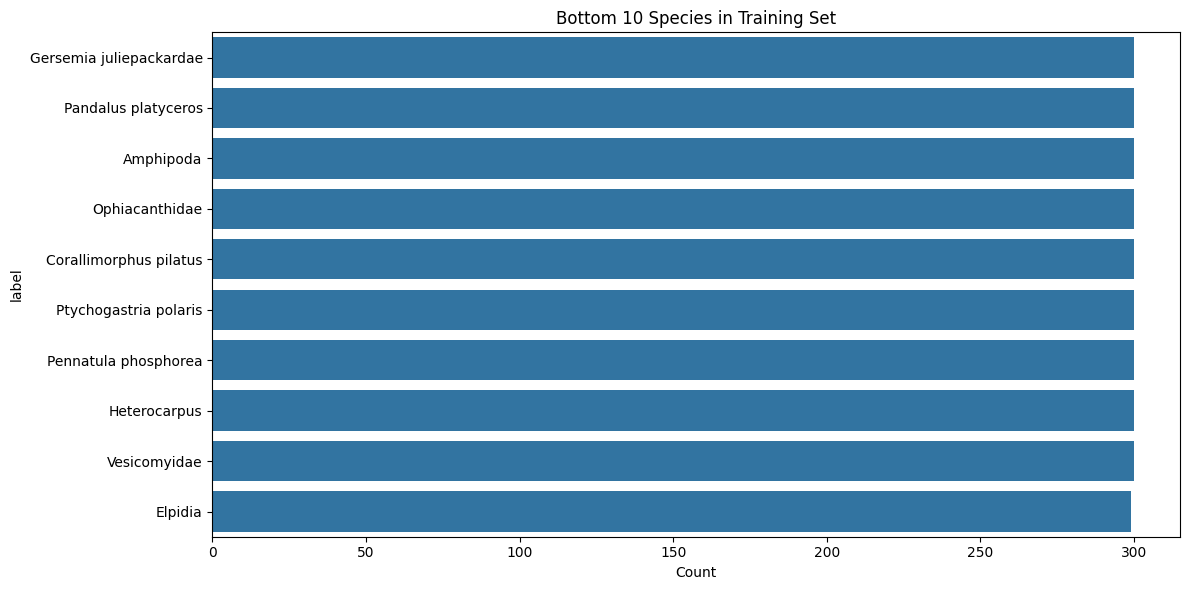


Test dataset: 788 images
Number of unique test labels: 79


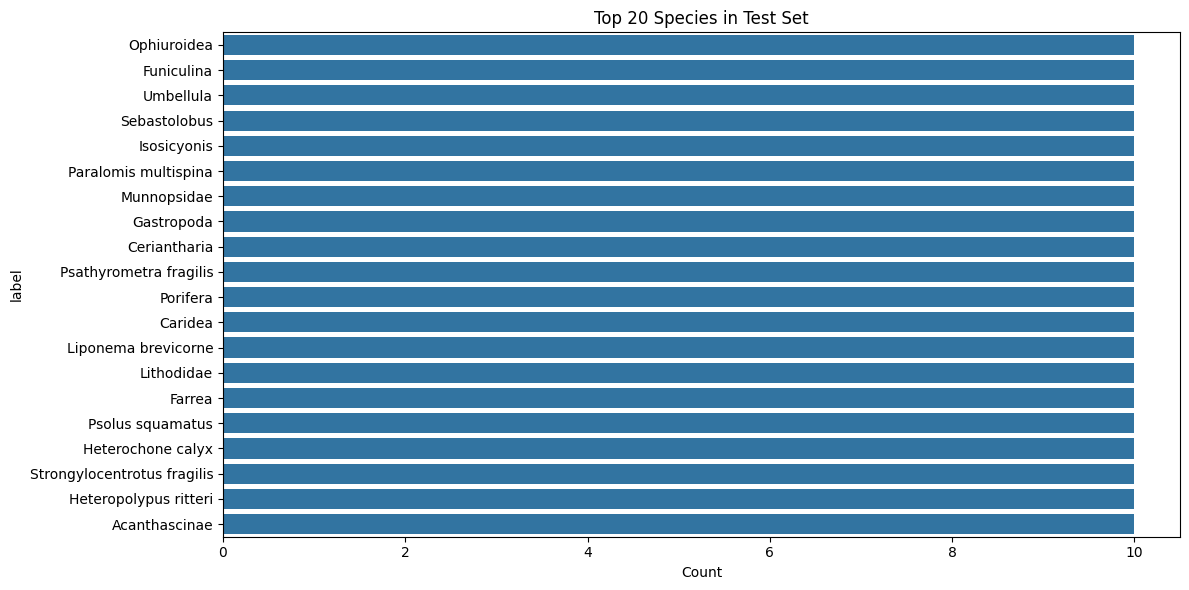


Visualizing sample images...


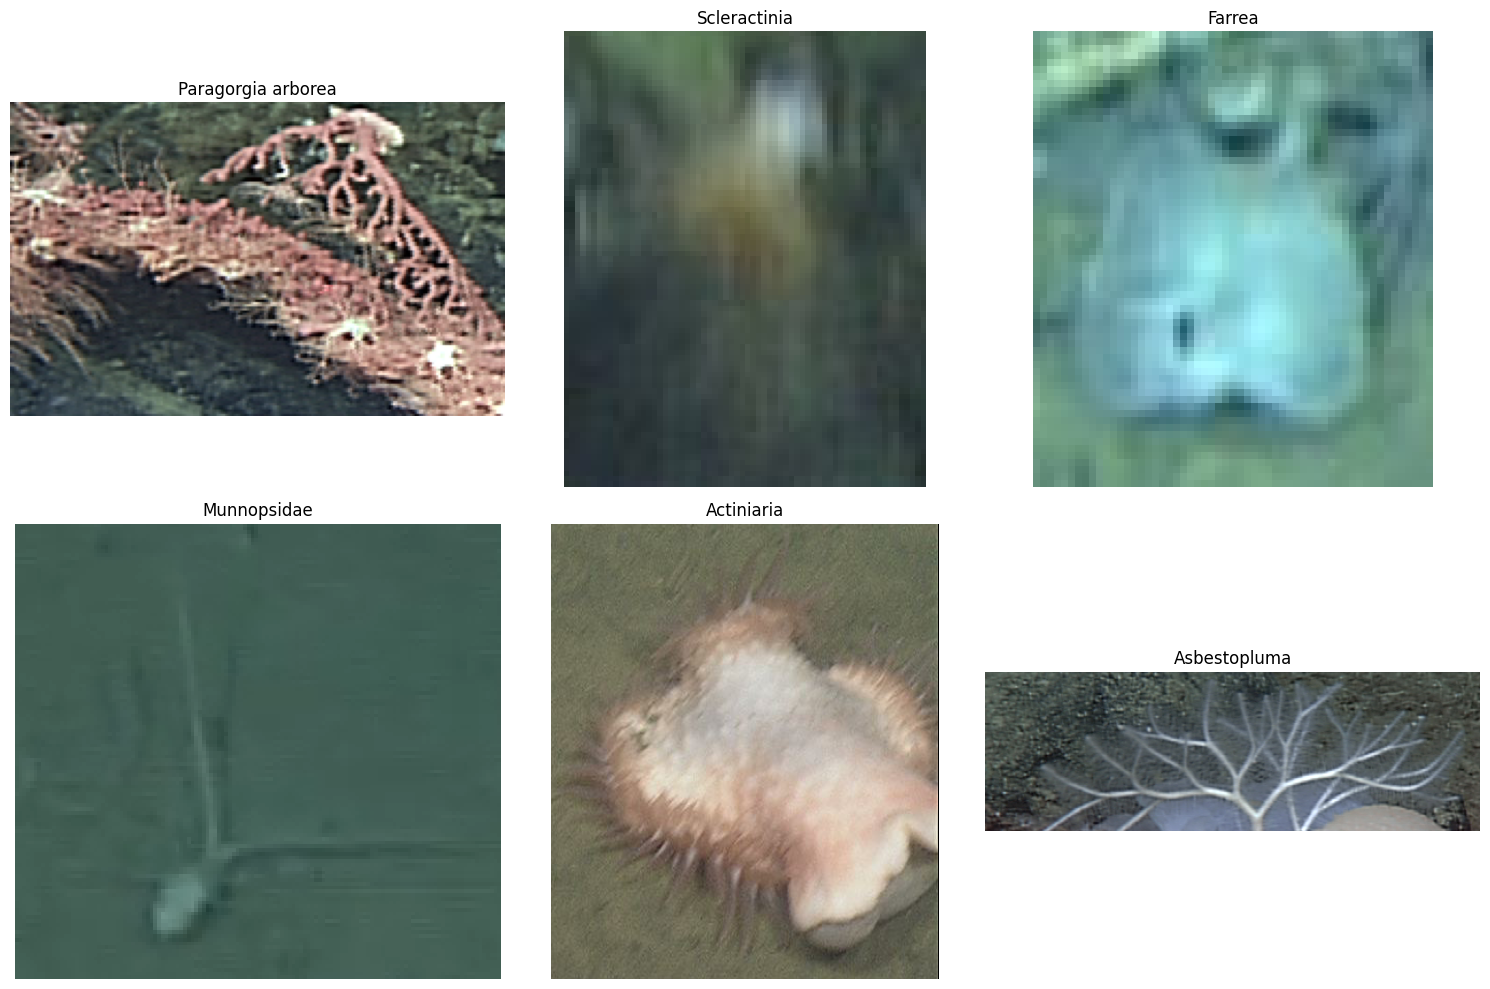


Analyzing image sizes...


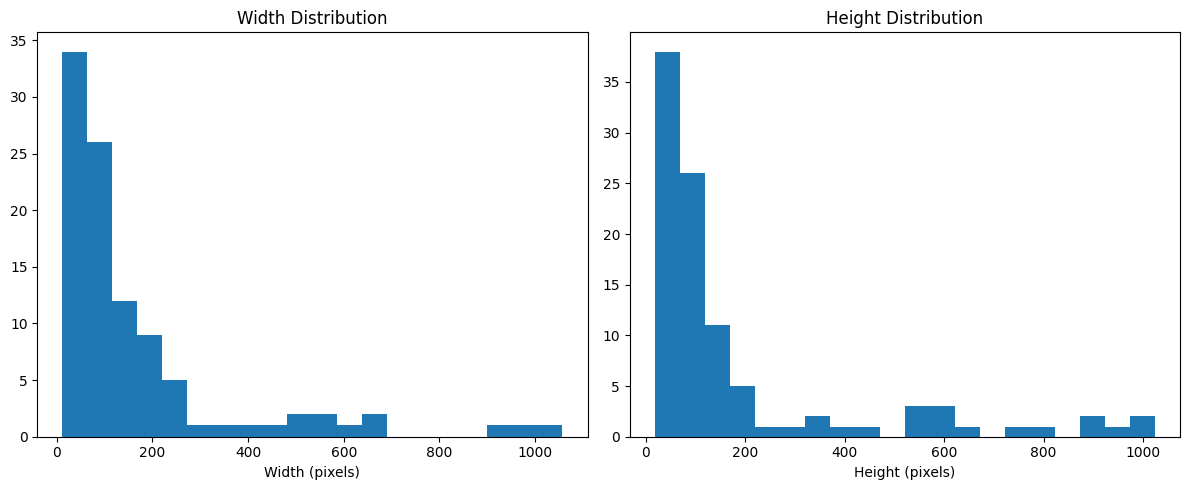

Median width: 97.5, Median height: 86.0

PREPARING TRAINING DATA
Preparing datasets...
Loading taxonomy data...
Kingdom :   2 classes
Phylum  :   8 classes
Class   :  22 classes
Order   :  43 classes
Family  :  66 classes
Genus   :  75 classes
Species :  80 classes
Train dataset: 16589 images
Validation dataset: 3555 images
Internal evaluation dataset: 3555 images


In [18]:
# Run data exploration
if RUN_EXPLORATION:
    print("Starting exploratory data analysis...")
    train_annotations = explore_dataset()
else:
    print("Skipping data exploration...")

# Always prepare training data (needed for taxonomy info)
print("\n" + "="*50)
print("PREPARING TRAINING DATA")
print("="*50)
train_loader, val_loader, eval_loader, taxonomy_df, encoders, class_counts, id_to_name, name_to_id = prepare_data()


In [20]:
if RUN_TRAINING:
    # print(f"CUDA available: {torch.cuda.is_available()}")
    # print(f"Number of GPUs: {torch.cuda.device_count()}")
    # for i in range(torch.cuda.device_count()):
    #     print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    #     print(f"Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.1f} GB")
    
    os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"  # Explicitly set all 8 GPUs
    os.environ["NCCL_DEBUG"] = "INFO"
    os.environ["NCCL_SOCKET_IFNAME"] = "^docker0,lo"  # Skip problematic interfaces
    os.environ["NCCL_IB_DISABLE"] = "1"  # Disable InfiniBand if causing issues
    
    # Train the model (this will take time!)
    torch.cuda.empty_cache()
    print("\n" + "CUDA cache cleared")
    print("\n" + "="*50)
    print("STARTING MODEL TRAINING")
    print("="*50 + "\n")
    best_model_path = train_model(train_loader, val_loader, class_counts)
    print(f"Best model saved at: {best_model_path}")
elif LOAD_PRETRAINED:
    # Load a pretrained model
    print("\n" + "="*50)
    print(f"LOADING PRETRAINED MODEL: {PRETRAINED_PATH}")
    print("="*50 + "\n")
    best_model_path = PRETRAINED_PATH
    
    # Verify the model exists
    if not os.path.exists(best_model_path):
        print(f"ERROR: Pretrained model not found at {best_model_path}")
        # Create a placeholder to avoid errors in later cells
        best_model_path = None
else:
    print("Skipping model training and not loading pretrained model...")
    # Skip both training and loading pretrained
    best_model_path = None


CUDA cache cleared

STARTING MODEL TRAINING

Starting model training...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA H200') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

   | Name              | Type             | Params | Mode 
----------------------------------------------------------------
0  | feature_extractor | ConvNeXt         | 87.7 M | train
1  | shared_features   | Sequential       | 1.1 M  | train
2  | kingdom_head      | Linear           | 2.0 K  | train
3  | kingdom_to_phylum | Linear           | 1.5 K  | train
4  | phylum_features   | Linear           | 524 K  | train
5  | phylum_

Epoch 0:  80%|███████▉  | 413/519 [00:32<00:08, 12.65it/s, v_num=44, train_loss=1.580]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
from pytorch_lightning import Trainer

model = TaxonomyAwareClassifier(class_counts=class_counts)
model.eval()

# This returns a scripted TorchScript model
scripted_model = model.to_torchscript(method="script")  # or "trace"
scripted_model.save("model_scripted.pt")


### Test Metrics


RUNNING INTERNAL EVALUATION METRICS



Internal Evaluation loop: 100%|██████████| 112/112 [00:05<00:00, 21.86it/s]



🧬 Kingdom Accuracy: 1.0000

📋 Kingdom Classification Report:
              precision    recall  f1-score   support

    Animalia       1.00      1.00      1.00      3555

    accuracy                           1.00      3555
   macro avg       1.00      1.00      1.00      3555
weighted avg       1.00      1.00      1.00      3555

Report saved to /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/outputs/internal_evaluation_kingdom_report.txt
Confusion matrix saved to /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/outputs/internal_evaluation_kingdom_confusion_matrix.png


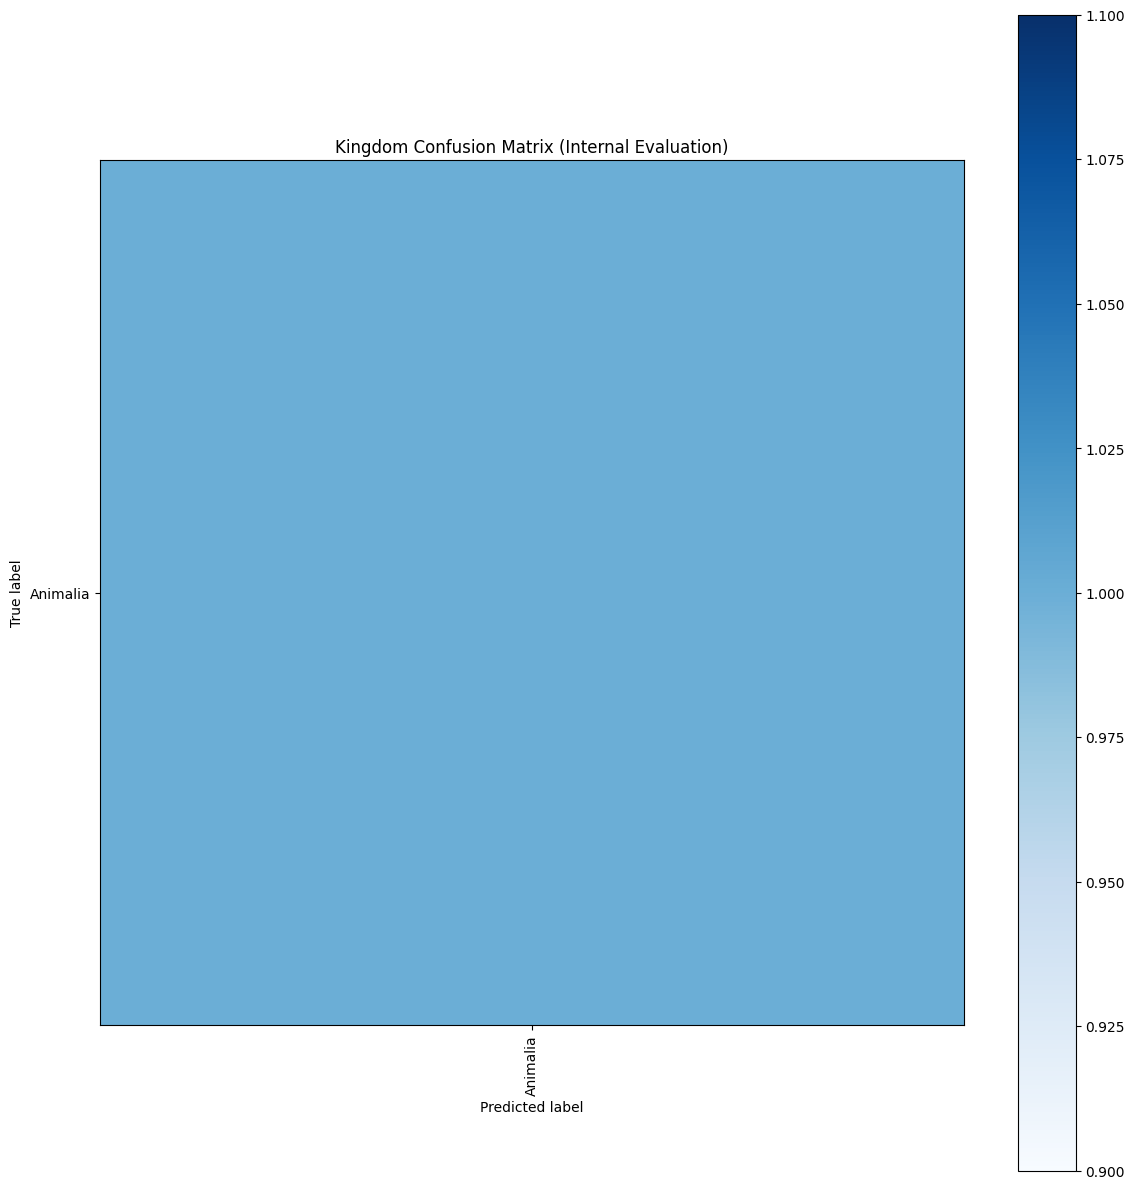


🧬 Phylum Accuracy: 0.9646

📋 Phylum Classification Report:
               precision    recall  f1-score   support

     Annelida       0.95      0.99      0.97        90
   Arthropoda       0.94      0.98      0.96       495
     Chordata       0.97      0.94      0.96       360
     Cnidaria       0.98      0.97      0.97      1080
Echinodermata       0.98      0.97      0.97       945
     Mollusca       0.94      0.92      0.93       180
     Porifera       0.93      0.97      0.95       405

     accuracy                           0.96      3555
    macro avg       0.96      0.96      0.96      3555
 weighted avg       0.96      0.96      0.96      3555

Report saved to /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/outputs/internal_evaluation_phylum_report.txt
Confusion matrix saved to /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/outputs/internal_evaluation_phylum_confusion_matrix.png


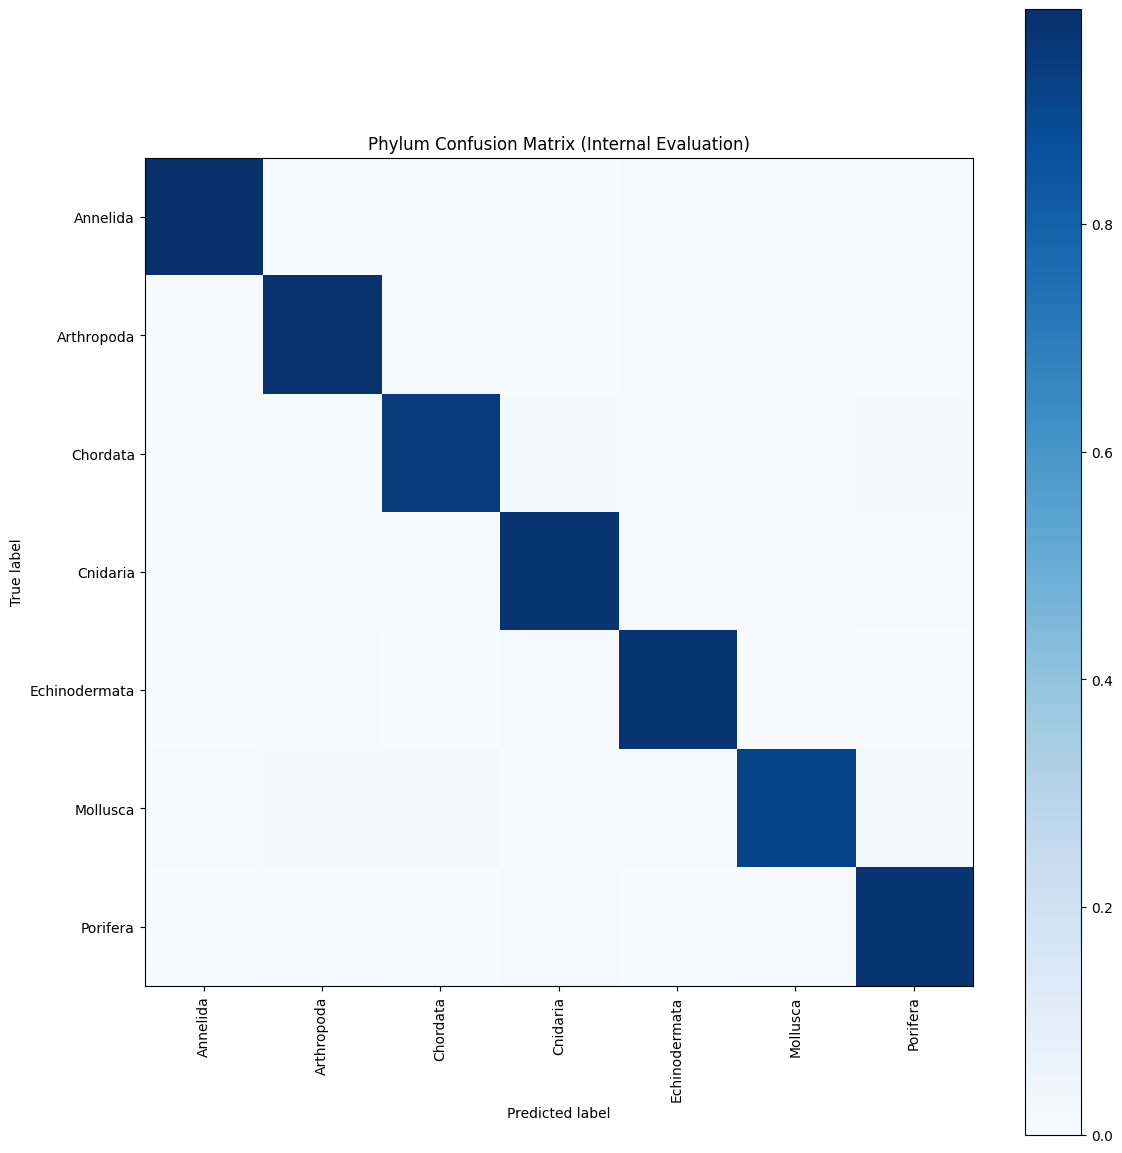


🧬 Class Accuracy: 0.9454

📋 Class Classification Report:
                precision    recall  f1-score   support

Actinopterygii       0.94      0.83      0.88        90
    Asteroidea       0.98      0.93      0.95       225
      Bivalvia       0.89      0.94      0.92        90
   Cephalopoda       0.98      0.89      0.93        45
     Crinoidea       0.97      0.97      0.97       135
  Demospongiae       0.91      0.95      0.93       135
    Echinoidea       0.98      0.98      0.98        45
    Gastropoda       0.84      0.82      0.83        45
  Hexacorallia       0.99      0.95      0.97       450
Hexactinellida       0.88      0.91      0.90       225
 Holothuroidea       0.96      0.98      0.97       450
      Hydrozoa       0.98      1.00      0.99        90
  Malacostraca       0.93      0.98      0.95       450
Multicrustacea       1.00      0.91      0.95        45
  Octocorallia       0.97      0.96      0.97       540
   Ophiuroidea       0.91      0.96      0.93

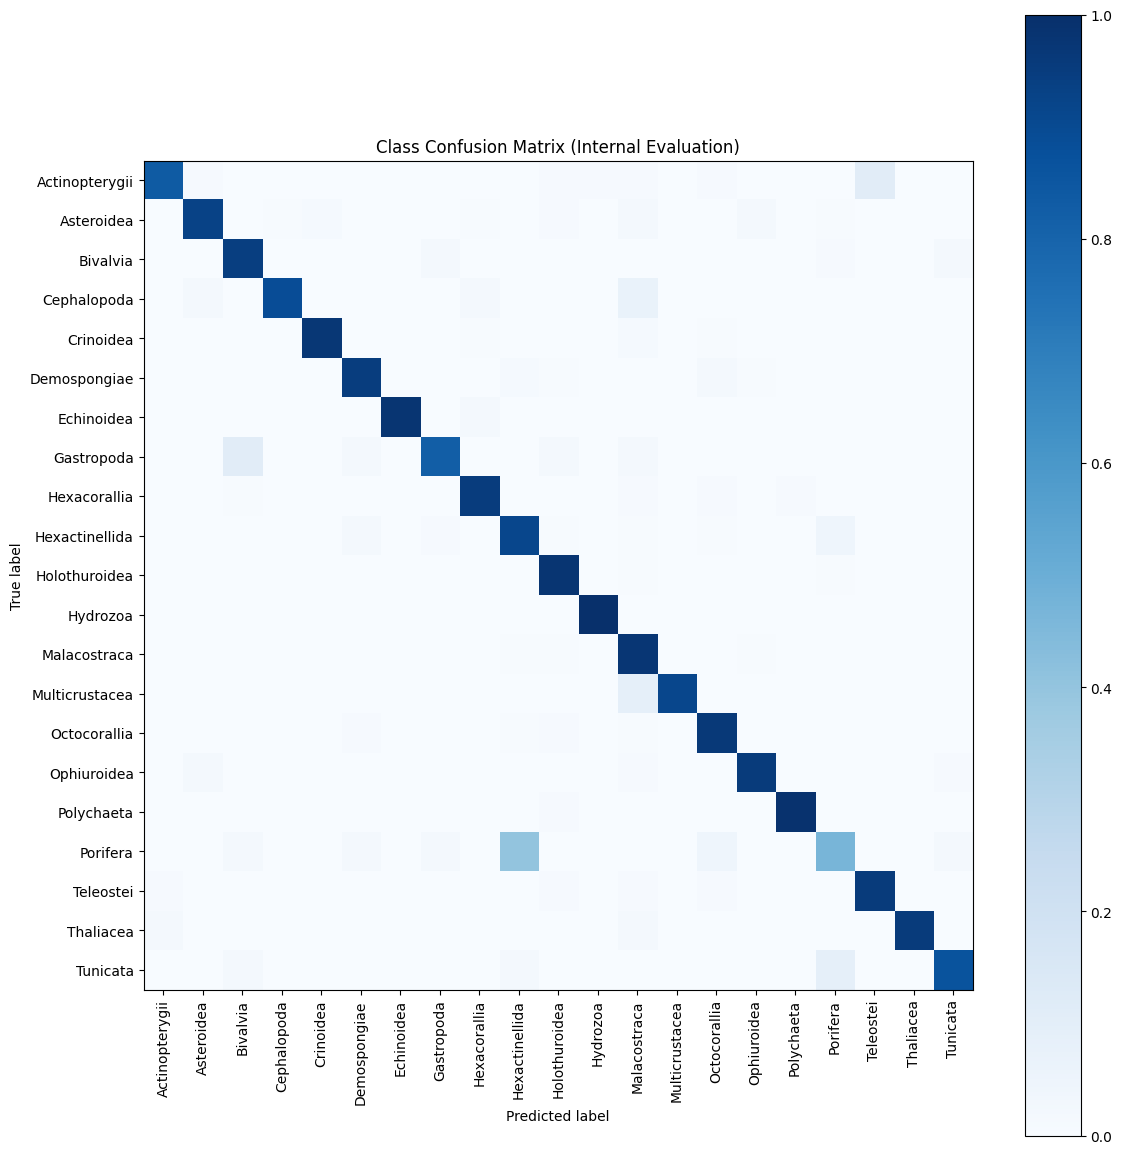


🧬 Order Accuracy: 0.9145

📋 Order Classification Report:
                   precision    recall  f1-score   support

       Actiniaria       0.95      0.93      0.94       270
   Actinopterygii       0.78      0.69      0.73        45
        Amphipoda       0.97      0.87      0.92        45
       Asteroidea       0.88      0.82      0.85        45
       Brisingida       0.97      0.84      0.90        45
      Camarodonta       0.98      0.96      0.97        45
     Ceriantharia       0.93      0.91      0.92        45
       Comatulida       0.91      0.91      0.91        90
 Corallimorpharia       1.00      0.82      0.90        45
        Crinoidea       0.81      0.78      0.80        45
         Decapoda       0.93      0.99      0.96       360
  Dendrochirotida       0.84      0.96      0.90        90
      Elasipodida       0.93      0.93      0.93       225
         Eucarida       1.00      0.93      0.97        45
   Forcipulatacea       0.96      1.00      0.98        

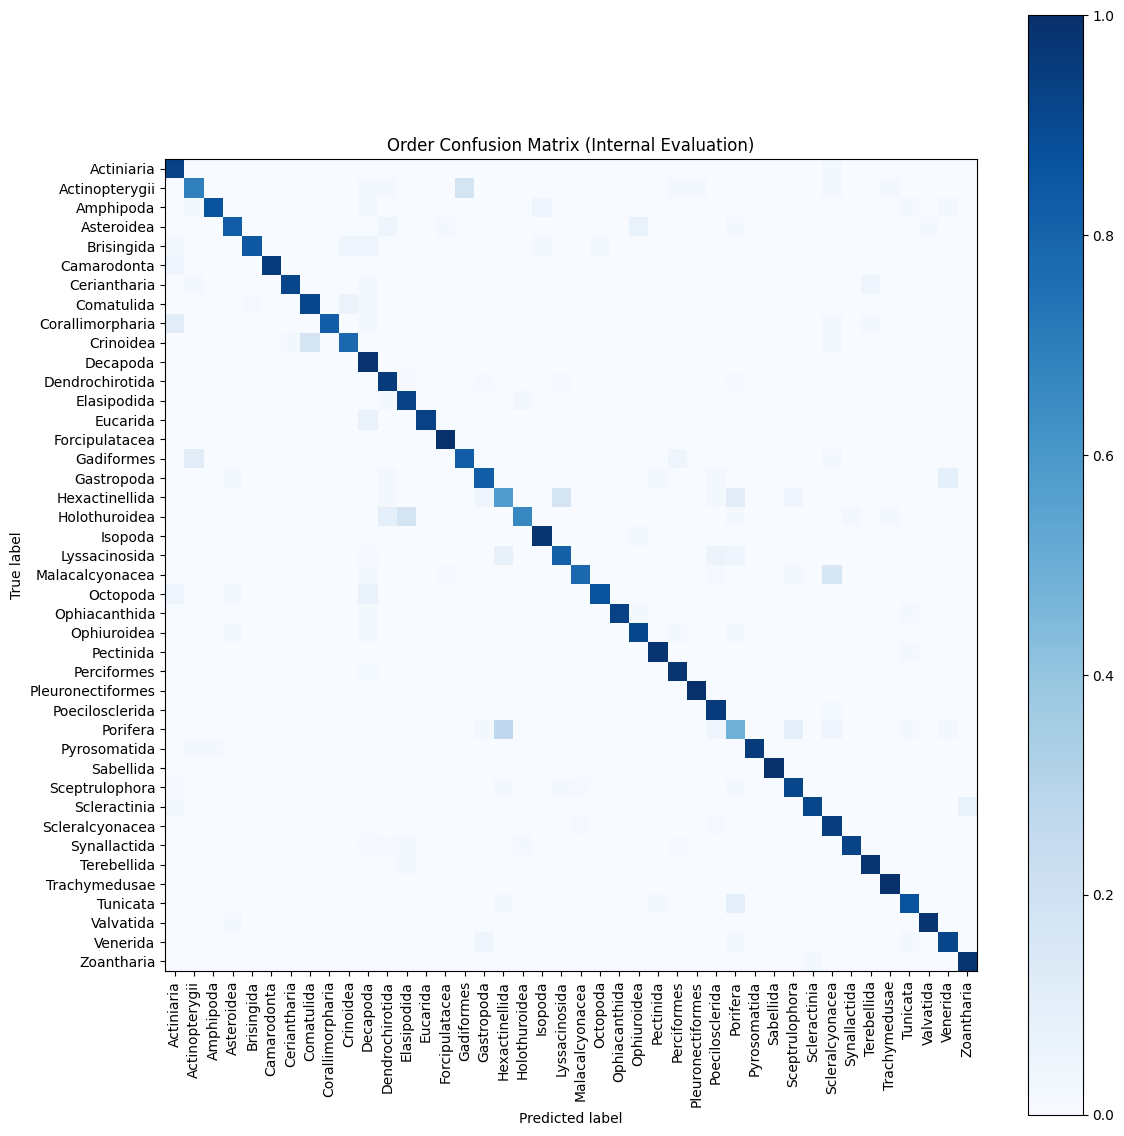


🧬 Family Accuracy: 0.8923

📋 Family Classification Report:
                      precision    recall  f1-score   support

       Actinernoidea       0.91      0.87      0.89        45
          Actiniaria       0.69      0.53      0.60        45
          Actiniidae       0.86      0.96      0.91        45
      Actinopterygii       0.74      0.69      0.71        45
         Alcyoniidae       0.98      0.91      0.94        45
           Amphipoda       0.98      0.91      0.94        45
        Antedonoidea       0.68      0.91      0.78        45
    Aphrocallistidae       0.91      0.91      0.91        45
          Asteriidae       0.98      1.00      0.99        45
          Asteroidea       0.86      0.80      0.83        45
          Brisingida       0.95      0.82      0.88        45
             Caridea       0.74      0.76      0.75        45
        Ceriantharia       0.89      0.91      0.90        45
       Cladorhizidae       0.92      0.94      0.93        90
         

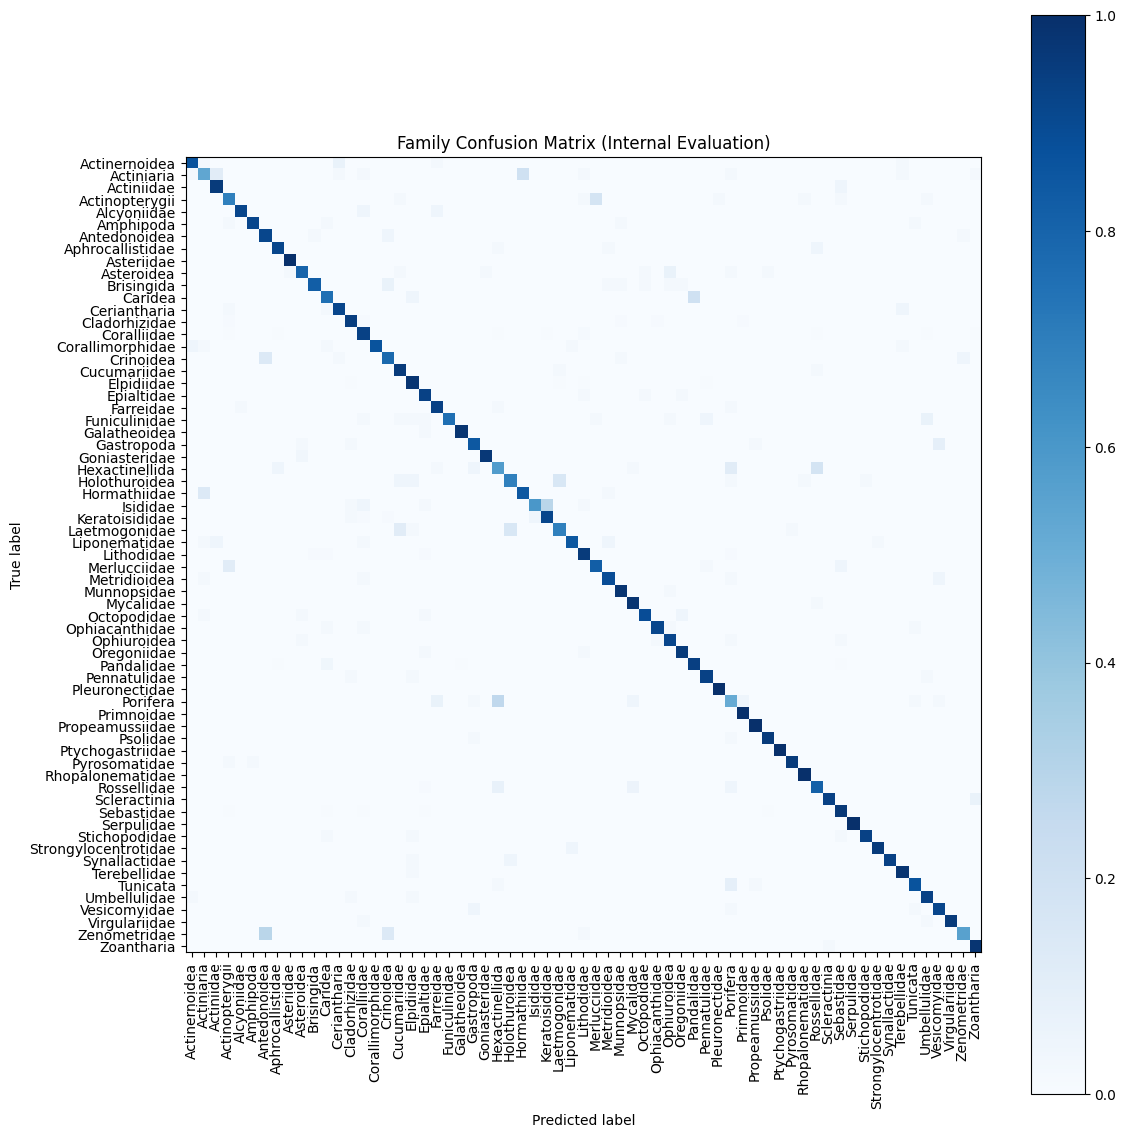


🧬 Genus Accuracy: 0.8835

📋 Genus Classification Report:
                    precision    recall  f1-score   support

     Abyssocucumis       0.83      0.96      0.89        45
     Acanthascinae       0.82      0.82      0.82        45
       Acanthascus       0.88      0.80      0.84        45
     Acanthoptilum       1.00      0.96      0.98        45
        Actinernus       0.91      0.87      0.89        45
        Actiniaria       0.68      0.56      0.61        45
    Actinopterygii       0.76      0.69      0.72        45
         Amphipoda       0.95      0.89      0.92        45
      Apostichopus       0.98      0.93      0.95        45
      Asbestopluma       0.92      0.96      0.94        90
        Asteroidea       0.88      0.82      0.85        45
       Benthocodon       0.96      1.00      0.98        45
        Brisingida       0.95      0.82      0.88        45
           Caridea       0.74      0.78      0.76        45
      Ceriantharia       0.93      0.91  

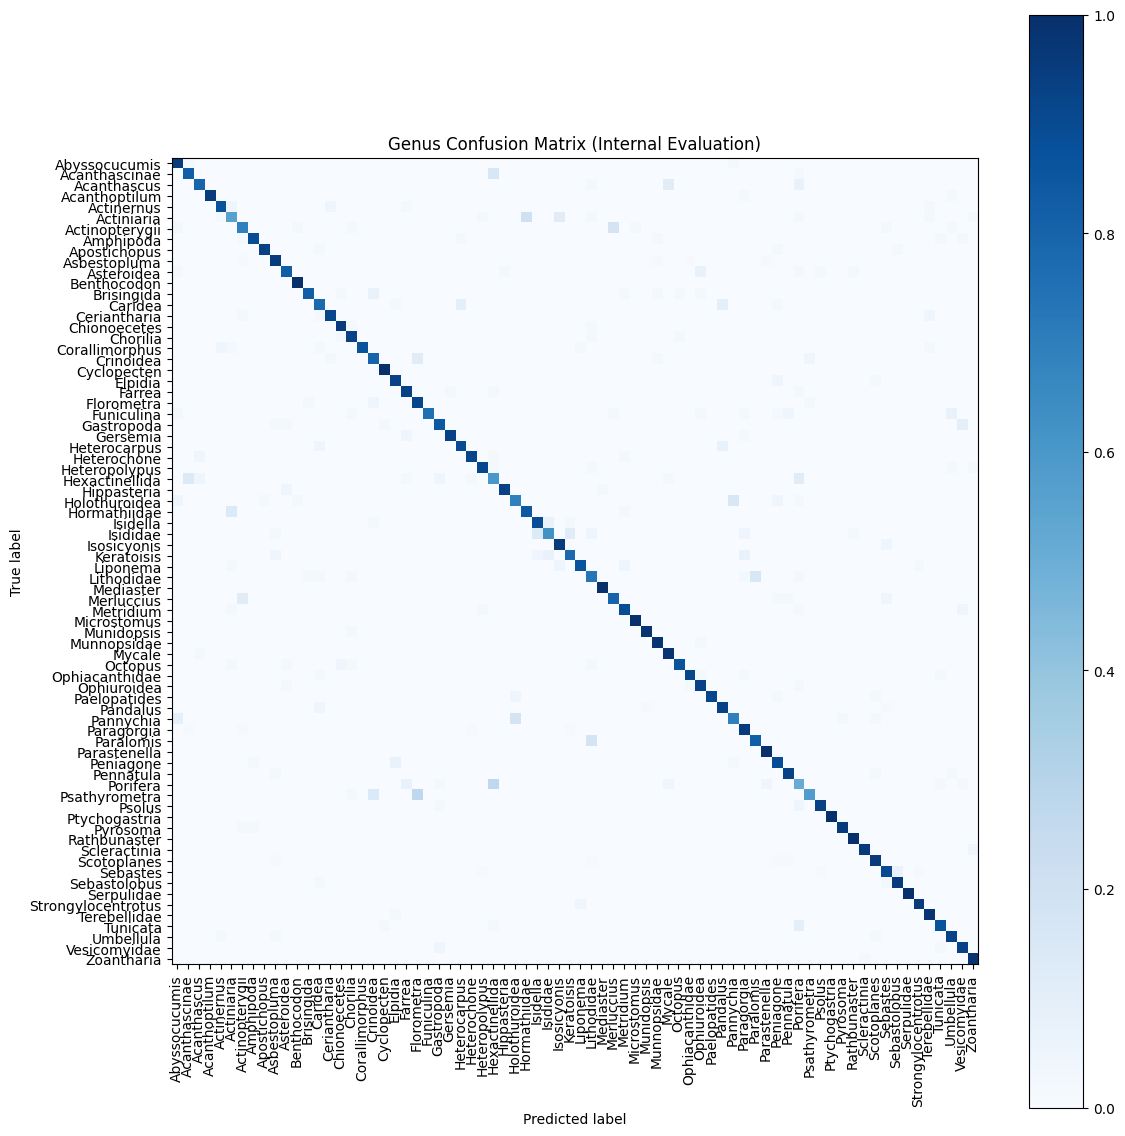


🧬 Species Accuracy: 0.8731

📋 Species Classification Report:
                             precision    recall  f1-score   support

    Abyssocucumis abyssorum       0.81      0.96      0.88        45
              Acanthascinae       0.82      0.82      0.82        45
              Acanthoptilum       1.00      0.96      0.98        45
                 Actinernus       0.91      0.87      0.89        45
                 Actiniaria       0.69      0.56      0.62        45
             Actinopterygii       0.74      0.69      0.71        45
                  Amphipoda       0.95      0.91      0.93        45
    Apostichopus leukothele       0.98      0.93      0.95        45
               Asbestopluma       0.89      0.89      0.89        45
     Asbestopluma monticola       0.91      0.93      0.92        45
                 Asteroidea       0.90      0.80      0.85        45
    Benthocodon pedunculata       0.96      1.00      0.98        45
                 Brisingida       0.95  

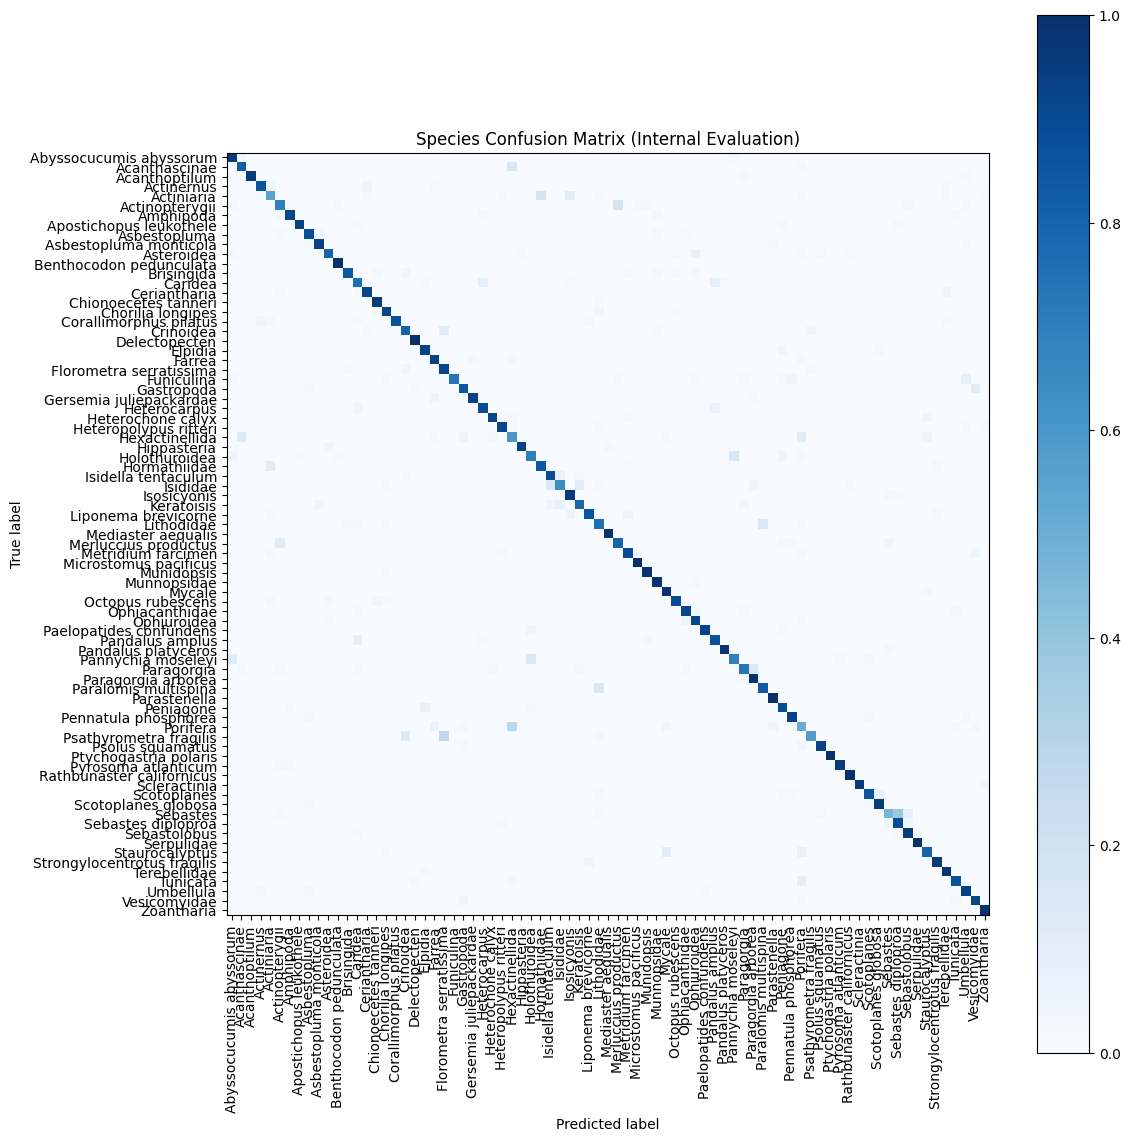

In [ ]:
model = TaxonomyAwareClassifier.load_from_checkpoint(
    best_model_path, 
    class_counts=class_counts
)
evaluate_model(model, eval_loader, class_counts, id_to_name, name="Internal Evaluation")

### Taxonomy-Aware Evaluation

In [ ]:
eval_dataset = eval_loader.dataset
save_ground_truths(eval_dataset, id_to_name, output_csv_path="ground_truths.csv")
save_predictions(model, eval_loader, id_to_name, output_csv_path="predictions.csv")

Ground truth CSV saved to: ground_truths.csv
Prediction CSV saved to: predictions.csv


In [ ]:
# Load files from the provided beegfs path
taxonomy = pd.read_csv("/mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/taxonomy.csv")
ground_truths = pd.read_csv("/mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/ground_truths.csv")
predictions = pd.read_csv("/mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/predictions.csv")
valid_species = pd.read_csv("/mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/species_79_labels.csv")["species"].astype(str).str.strip().tolist()

# Ensure proper structure
taxonomy = taxonomy[["species", "genus", "family", "order", "class", "phylum", "kingdom"]]
taxonomy = taxonomy.dropna().astype(str).apply(lambda col: col.str.strip())

# Build the full taxonomy tree
import networkx as nx

G = nx.DiGraph()
for _, row in taxonomy.iterrows():
    G.add_edge("root", row["kingdom"])
    G.add_edge(row["kingdom"], row["phylum"])
    G.add_edge(row["phylum"], row["class"])
    G.add_edge(row["class"], row["order"])
    G.add_edge(row["order"], row["family"])
    G.add_edge(row["family"], row["genus"])
    G.add_edge(row["genus"], row["species"])

# Ensure all valid species are in the graph
for label in valid_species:
    if label not in G:
        G.add_node(label)
        G.add_edge("root", label)

# Merge predictions and ground truths
df = pd.merge(ground_truths, predictions, on="annotation_id", suffixes=("_true", "_pred"))

# Compute taxonomy-aware distance
def taxonomic_tree_distance(true_name, pred_name):
    if true_name not in G.nodes or pred_name not in G.nodes:
        return 12
    try:
        return nx.shortest_path_length(G.to_undirected(), source=true_name, target=pred_name)
    except nx.NetworkXNoPath:
        return 12

df["taxonomic_distance"] = df.apply(
    lambda row: taxonomic_tree_distance(row["concept_name_true"], row["concept_name_pred"]), axis=1
)

# Final score
mean_score = df["taxonomic_distance"].mean()
mean_score


np.float64(0.6306610407876231)

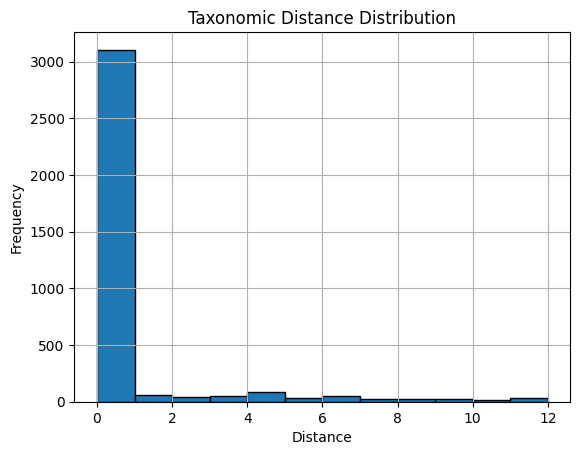

In [ ]:
import matplotlib.pyplot as plt
df["taxonomic_distance"].hist(bins=range(13), edgecolor="black")
plt.title("Taxonomic Distance Distribution")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()


In [ ]:
df[df["taxonomic_distance"] >= 3].sort_values("taxonomic_distance", ascending=False).head(100)

,annotation_id,concept_name_true,concept_name_pred,taxonomic_distance
3425,3425,Strongylocentrotus fragilis,Liponema brevicorne,12
3427,3427,Octopus rubescens,Chionoecetes tanneri,12
713,713,Staurocalyptus,Chorilia longipes,12
2532,2532,Chorilia longipes,Octopus rubescens,12
1259,1259,Octopus rubescens,Chorilia longipes,12
...,...,...,...,...
218,218,Pannychia moseleyi,Abyssocucumis abyssorum,8
140,140,Umbellula,Actinernus,8
64,64,Gersemia juliepackardae,Paragorgia arborea,8
42,42,Actiniaria,Lithodidae,7


In [ ]:
invalid_preds = df[~df["concept_name_pred"].isin(valid_species)]
print(f"🚨 Invalid predictions (not in 79-species list): {len(invalid_preds)}")
print(invalid_preds["concept_name_pred"].value_counts().head())


🚨 Invalid predictions (not in 79-species list): 0
Series([], Name: count, dtype: int64)


In [ ]:
lengths = [nx.shortest_path_length(G, "root", n) for n in valid_species if G.has_node(n)]
print(f"Max taxonomy depth: {max(lengths)}")


Max taxonomy depth: 7


### Submission

In [86]:
# Generate submission if we have a model
if GENERATE_SUBMISSION and best_model_path is not None:
    print("\n" + "="*50)
    print("PREPARING TEST DATA")
    print("="*50)
    test_loader = prepare_test_data(taxonomy_df)

    # Generate submission
    print("\n" + "="*50)
    print("GENERATING SUBMISSION")          
    print("="*50)
    
    submission_df = generate_submission(
        model_path=best_model_path,
        test_loader=test_loader,
        class_counts=class_counts,
        id_to_name=id_to_name,
        taxonomy_df=taxonomy_df
    )
    
    print(f"\nSubmission saved to: {Config.SUBMISSION_PATH}")
    print(f"Top submission classes:")
    print(submission_df['concept_name'].value_counts().head(10))
else:
    if best_model_path is None:
        print("Skipping submission generation: No model available")
    else:
        print("Skipping submission generation...")


PREPARING TEST DATA
Preparing test dataset...
Using row indices (0 to 787) as annotation IDs
Test dataset: 788 images

GENERATING SUBMISSION
Generating submission file...
Running inference on: cuda


Processing test data: 100%|██████████| 25/25 [00:01<00:00, 15.50it/s]

Submission saved to /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/submission.csv

Prediction distribution:
  Paragorgia: 28 (3.6%)
  Umbellula: 22 (2.8%)
  Sebastes: 21 (2.7%)
  Scotoplanes: 20 (2.5%)
  Porifera: 18 (2.3%)
  Asteroidea: 17 (2.2%)
  Acanthoptilum: 17 (2.2%)
  Elpidia: 16 (2.0%)
  Benthocodon pedunculata: 16 (2.0%)
  Psolus squamatus: 16 (2.0%)

Submission saved to: /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/submission.csv
Top submission classes:
concept_name
Paragorgia                 28
Umbellula                  22
Sebastes                   21
Scotoplanes                20
Porifera                   18
Asteroidea                 17
Acanthoptilum              17
Elpidia                    16
Benthocodon pedunculata    16
Psolus squamatus           16
Name: count, dtype: int64


In [ ]:
import os
import subprocess
import shutil

os.environ['KAGGLE_USERNAME'] = "****************"
os.environ['KAGGLE_KEY'] = "****************"

kaggle_path = shutil.which("kaggle")

result = subprocess.run([
    kaggle_path, "competitions", "submit", 
    "-c", "fathomnet-2025", 
    "-f", "submission.csv", 
    "-m", "Auto-submission"
], capture_output=True, text=True)

print("STDOUT:\n", result.stdout)
print("STDERR:\n", result.stderr)

if result.returncode != 0:
    print("Submission failed.")
else:
    print("Submission succeeded.")


STDOUT:
 Successfully submitted to FathomNet 2025 @ CVPR-FGVC
STDERR:
 
  0%|          | 0.00/14.3k [00:00<?, ?B/s]
100%|██████████| 14.3k/14.3k [00:00<00:00, 141kB/s]
100%|██████████| 14.3k/14.3k [00:00<00:00, 45.2kB/s]

Submission succeeded.


In [88]:
import pandas as pd

df = pd.read_csv("submission.csv")

# Basic structure checks
assert list(df.columns) == ["annotation_id", "concept_name"], "Wrong column headers"
assert df["annotation_id"].is_unique, "Duplicate annotation_id"
assert df["annotation_id"].min() == 1, "IDs must start at 1"
assert df["annotation_id"].max() == len(df), "IDs must be consecutive"
assert df["concept_name"].notna().all(), "Found NaN in concept_name"
assert df["concept_name"].apply(lambda x: isinstance(x, str) and x.strip() != "").all(), "Empty or non-string values in concept_name"

print("submission.csv passed all checks.")


submission.csv passed all checks.


In [89]:
# Load taxonomy
taxonomy_df = pd.read_csv(Config.TAXONOMY_PATH)
valid_species = set(taxonomy_df["species"].dropna().astype(str).str.strip())

# Load submission
submission_df = pd.read_csv("submission.csv")

# Check for invalid species names
invalid_names = submission_df[
    ~submission_df["concept_name"].isin(valid_species)
]

print(f"Found {len(invalid_names)} invalid concept names:")
print(invalid_names.head())


Found 0 invalid concept names:
Empty DataFrame
Columns: [annotation_id, concept_name]
Index: []


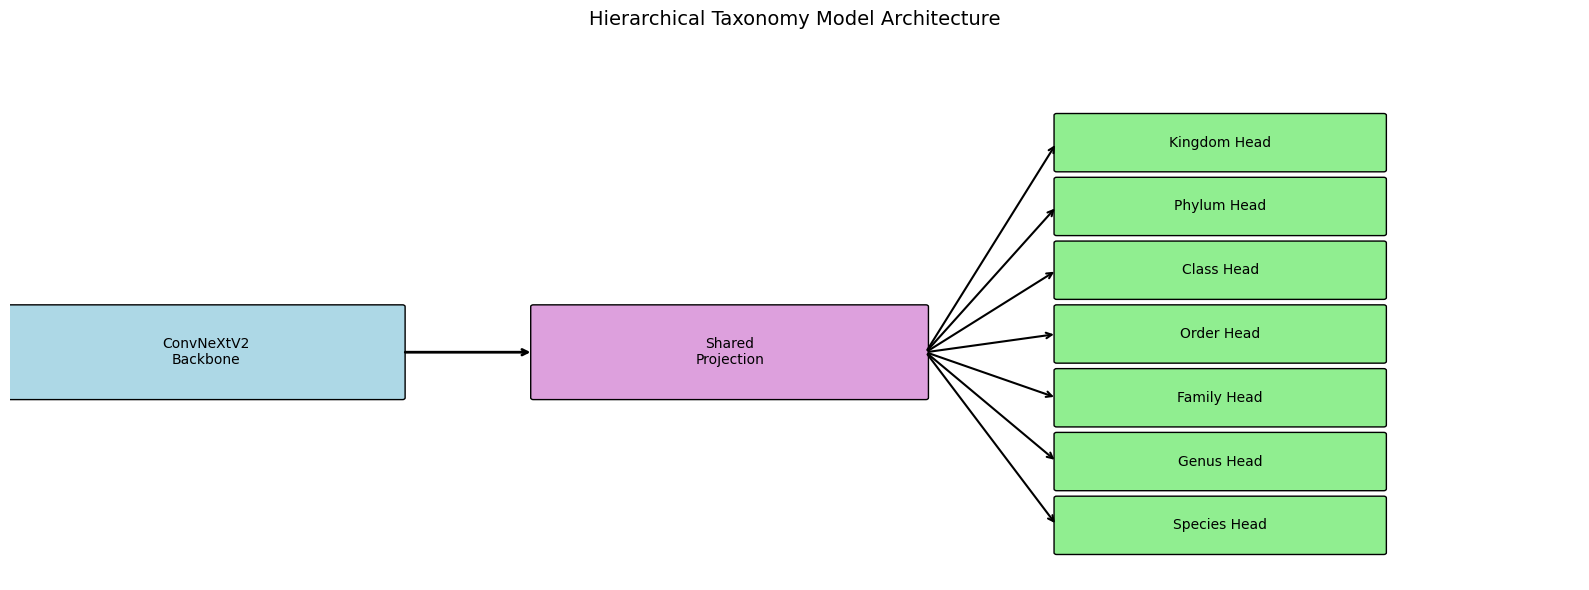

In [93]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_model_diagram():
    fig, ax = plt.subplots(figsize=(16, 6))

    # Backbone
    ax.add_patch(patches.FancyBboxPatch((0, 2), 3, 1, boxstyle="round,pad=0.02", fc="lightblue", ec="black"))
    ax.text(1.5, 2.5, "ConvNeXtV2\nBackbone", ha='center', va='center')

    # Shared projection
    ax.add_patch(patches.FancyBboxPatch((4, 2), 3, 1, boxstyle="round,pad=0.02", fc="plum", ec="black"))
    ax.text(5.5, 2.5, "Shared\nProjection", ha='center', va='center')

    # Arrows between backbone and projection
    ax.annotate('', xy=(4, 2.5), xytext=(3, 2.5),
                arrowprops=dict(arrowstyle="->", lw=2))

    # Classification heads
    head_names = ["Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species"]
    for i, name in enumerate(head_names):
        x = 8
        y = 4.5 - i * 0.7
        ax.add_patch(patches.FancyBboxPatch((x, y), 2.5, 0.6, boxstyle="round,pad=0.02", fc="lightgreen", ec="black"))
        ax.text(x + 1.25, y + 0.3, f"{name} Head", ha='center', va='center')
        ax.annotate('', xy=(x, y + 0.3), xytext=(7, 2.5),
                    arrowprops=dict(arrowstyle="->", lw=1.5))

    ax.set_xlim(0, 12)
    ax.set_ylim(0, 6)
    ax.axis('off')
    plt.title("Hierarchical Taxonomy Model Architecture", fontsize=14)
    plt.tight_layout()
    plt.show()

draw_model_diagram()


In [19]:
import torch

# Make sure the model is on CPU or GPU as needed
model = model.to('cuda')  # or 'cuda' if GPU is supported
model.eval()

# Create a dummy input matching your input image size
dummy_input = torch.randn(1, 3, 224, 224)

# Export model to ONNX
torch.onnx.export(
    model,                       # Your full LightningModule
    dummy_input,                 # Dummy input
    "fathomnet_hierarchical_model.onnx",  # Output filename
    export_params=True,
    opset_version=12,            # Use 11, 12, or 13 depending on deployment needs
    do_constant_folding=True,
    input_names=['input'],
    output_names=[
        'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species'
    ],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'kingdom': {0: 'batch_size'},
        'phylum': {0: 'batch_size'},
        'class': {0: 'batch_size'},
        'order': {0: 'batch_size'},
        'family': {0: 'batch_size'},
        'genus': {0: 'batch_size'},
        'species': {0: 'batch_size'}
    }
)


NameError: name 'model' is not defined